# Convolutional Network for Pneumonia discrimination from X-Rays plates

This is a simple CNN for Pneumonia discrimination. Great accuracy is not expected since most models developed use transfer learning for a great accuracy. It is a guideline to follow for complex CNN

Dataset can be downloaded from the [Kaggle Pneumonia  dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)


## Importing libraries


In [1]:
import os
import numpy as np
import pandas as pd
import random
#import cv2
import matplotlib.pyplot as plt

%matplotlib inline

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D,Flatten, Dropout, Input, BatchNormalization
from keras.layers import SeparableConv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

Using TensorFlow backend.


In [2]:
seed =123
np.random.seed(seed)
tf.random.set_seed(seed)

## Extracting data 
Data is located in chest_ray folder. It is already separated in train, validation and test sets.

In [3]:
input_path = './chest_xray/'

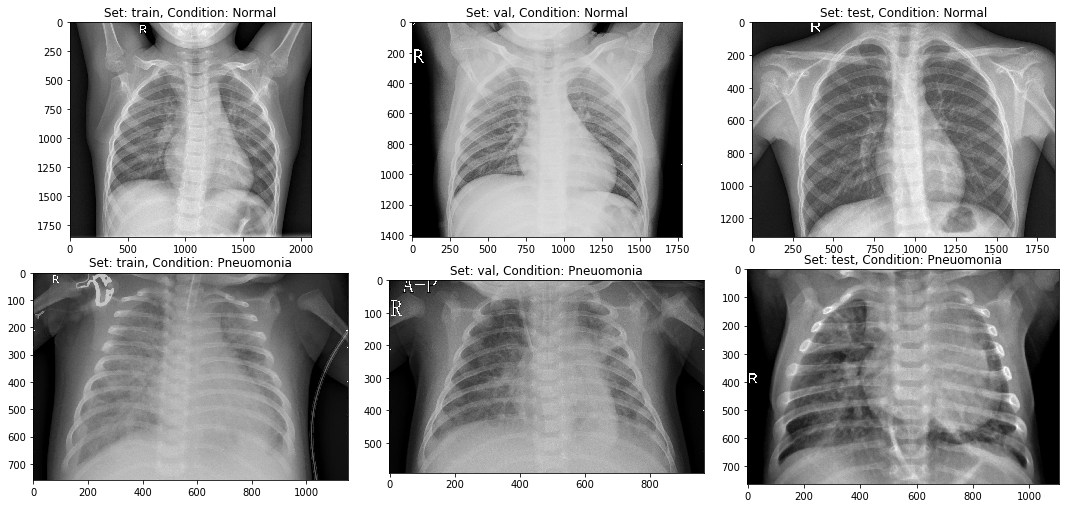

In [4]:
fig, axes = plt.subplots(2,3, figsize=(15,7))
axes = axes.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path + _set
    axes[i].imshow(plt.imread(set_path + '/NORMAL/' + os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    axes[i].set_title('Set: {}, Condition: Normal'.format(_set))
    axes[i+3].imshow(plt.imread(set_path + '/PNEUMONIA/' + os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    axes[i+3].set_title('Set: {}, Condition: Pneuomonia'.format(_set))
                      


From images we can observe that they have different proportions, which must be taken into account by transforming them into a adecuate proportions before feeding to the network. This will be done later.
But before, we have to separate mix up the normal and pneumonia plates to form the final train, validation and test set that will be used.

In [5]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


The test data will be used in training and validation to evaluate the model after.

## Data augmentation
We will use data augmentation in order to "create" an expansion of the dataset for training. This will be done since the CNN will have a lot of parameters, but the training set is not that large. For this, we will use the same images and then rotate them and change the ratio. This is achieved through the use of _data generators_ that will act into training and validation sets. A data generator is capable of loading data in mini-batches *on the fly* at training and not really by reating new images from in advanced.

In [6]:
#Forgot to import skimage library for resizing image in data augmentation
from skimage.transform import rescale, resize, downscale_local_mean

In [23]:


def process_data(img_dims, batch_size):
    #Data generation
    #The first argument rescale, will rescale the image according to pixels brightness. 
    #Second zoom_range will zoom the image
    #Third argument flips up the image
    train_data_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    val_data_gen = ImageDataGenerator(rescale = 1./255)
    
    #This will be fed to the CNN in the specified batch size and image dimension
    train_gen = train_data_gen.flow_from_directory(directory=input_path+'train',
                                                   target_size = (img_dims, img_dims), batch_size = batch_size, class_mode='binary', shuffle=True)
    
    val_gen = val_data_gen.flow_from_directory(directory=input_path+'test', target_size=(img_dims,img_dims), batch_size = batch_size, 
                                               class_mode='binary', shuffle=True)
    
    
    test_data = []
    test_labels = []
    
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'val' + cond)):
            img = plt.imread(input_path + 'val' + cond + img)
            img = resize(img, (img_dims, img_dims))
            img = np.dstack([img,img,img])
            img = img.astype('float32')/255
            
            if cond == '/NORMAL/':
                label = 0
            elif cond == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
        
    return train_gen, val_gen, test_data, test_labels

In [30]:
#Setting parameters
img_dims = 150
epochs = 20
batch_size = 64

train_gen, val_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Building the model


In [31]:
#inputs = Input(shape=(img_dims,img_dims,3))

#Convolutional blocks
model = Sequential()

model.add(Conv2D(16,kernel_size = 3, activation = 'relu', padding = 'same', input_shape = (img_dims, img_dims, 3)))
model.add(Conv2D(16,kernel_size = 3, activation = 'relu', padding = 'same', input_shape = (img_dims, img_dims, 3)))
model.add(MaxPool2D(2))

model.add(Conv2D(32,kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(Conv2D(32,kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2))


model.add(Conv2D(64, kernel_size=3, activation='relu', padding = 'same'))
model.add(Conv2D(64, kernel_size=3, activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2))


model.add(Conv2D(128, kernel_size=3, activation='relu', padding = 'same'))
model.add(Conv2D(128, kernel_size=3, activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2))

model.add(Conv2D(256, kernel_size=3, activation='relu', padding = 'same'))
model.add(Conv2D(256, kernel_size=3, activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2))


model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, activation ='relu'))
model.add(Dense(64, activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid'))



In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [34]:
checkpoint = ModelCheckpoint('best_weights.hdf5', save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=2, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)


In [ ]:
train_history = model.fit_generator(train_gen, steps_per_epoch=train_gen.samples // batch_size, 
                                    epochs = epochs, validation_data=val_gen, 
                                    validation_steps=val_gen.samples // batch_size, callbacks=[checkpoint,  early_stopping])

Epoch 1/20
81/81 [==============================] - 87s 1s/step - loss: 0.3306 - accuracy: 0.8614 - val_loss: 1.2594 - val_accuracy: 0.6128
Epoch 2/20
81/81 [==============================] - 101s 1s/step - loss: 0.2045 - accuracy: 0.9181 - val_loss: 2.8040 - val_accuracy: 0.6339
Epoch 3/20
81/81 [==============================] - 95s 1s/step - loss: 0.1744 - accuracy: 0.9325 - val_loss: 5.9766 - val_accuracy: 0.6357
Epoch 4/20
81/81 [==============================] - 96s 1s/step - loss: 0.1694 - accuracy: 0.9356 - val_loss: 6.1629 - val_accuracy: 0.6125
Epoch 5/20
81/81 [==============================] - 101s 1s/step - loss: 0.1604 - accuracy: 0.9385 - val_loss: 0.9834 - val_accuracy: 0.4875
Epoch 6/20
81/81 [==============================] - 104s 1s/step - loss: 0.1512 - accuracy: 0.9424 - val_loss: 0.5080 - val_accuracy: 0.7429
Epoch 7/20
81/81 [==============================] - 101s 1s/step - loss: 0.1408 - accuracy: 0.9480 - val_loss: 4.2259 - val_accuracy: 0.6464
Epoch 8/20
81/81

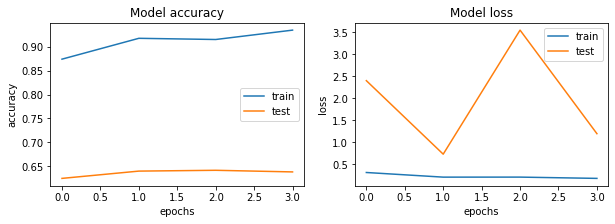

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(train_history.history[met])
    ax[i].plot(train_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'test'])

In [44]:
test_evaluation = model.evaluate(test_data,test_labels, verbose =1)
print("Loss on test set: {}".format(test_evaluation[0]))
print("Accuracy on test set: {}".format(test_evaluation[1]))

16/16 [==============================] - 0s 13ms/step
Loss on test set: 9.18791675567627
Accuracy on test set: 0.5


From the results, it is easy to observe how the simplicity of the network dificults a good learning by the "oscillations" on the test set. Let's try by adding some dropout layers

## Building a model with dropout layers


In [12]:
#inputs = Input(shape=(img_dims,img_dims,3))

#Convolutional blocks
model_drop = Sequential()

#Firts block
model_drop.add(Conv2D(16,kernel_size = 3, activation = 'relu', padding = 'same', input_shape = (img_dims, img_dims, 3)))
model_drop.add(Conv2D(16,kernel_size = 3, activation = 'relu', padding = 'same', input_shape = (img_dims, img_dims, 3)))
model_drop.add(MaxPool2D(2))

#Second
model_drop.add(SeparableConv2D(32,kernel_size = 3, activation = 'relu', padding = 'same'))
model_drop.add(SeparableConv2D(32,kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model_drop.add(MaxPool2D(2))


model_drop.add(SeparableConv2D(64, kernel_size=3, activation='relu', padding = 'same'))
model_drop.add(SeparableConv2D(64, kernel_size=3, activation='relu', padding = 'same'))
model.add(BatchNormalization())
model_drop.add(MaxPool2D(2))


model_drop.add(SeparableConv2D(128, kernel_size=3, activation='relu', padding = 'same'))
model_drop.add(SeparableConv2D(128, kernel_size=3, activation='relu', padding = 'same'))
model.add(BatchNormalization())
model_drop.add(MaxPool2D(2))
model_drop.add(Dropout(rate = 0.2))

model_drop.add(SeparableConv2D(256, kernel_size=3, activation='relu', padding = 'same'))
model_drop.add(SeparableConv2D(256, kernel_size=3, activation='relu', padding = 'same'))
model.add(BatchNormalization())
model_drop.add(MaxPool2D(2))
model_drop.add(Dropout(0.2))


model_drop.add(Flatten())
model_drop.add(Dense(512, activation = 'relu'))
model_drop.add(Dropout(rate = 0.5))
model_drop.add(Dense(128, activation ='relu'))
model_drop.add(Dropout(rate = 0.5))
model_drop.add(Dense(64, activation = 'relu'))
model_drop.add(Dropout(rate = 0.3))

model_drop.add(Dense(1, activation = 'sigmoid'))

In [13]:
model_drop.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [14]:
train_drop_history = model_drop.fit_generator(train_gen, steps_per_epoch=train_gen.samples // batch_size, 
                                    epochs = epochs, validation_data=val_gen, 
                                    validation_steps=val_gen.samples // batch_size, callbacks=[checkpoint, early_stopping])

Epoch 1/20
163/163 [==============================] - 130s 800ms/step - loss: 0.5914 - accuracy: 0.7391 - val_loss: 0.8995 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 97s 593ms/step - loss: 0.5791 - accuracy: 0.7429 - val_loss: 0.6794 - val_accuracy: 0.6267
Epoch 3/20
163/163 [==============================] - 105s 642ms/step - loss: 0.5744 - accuracy: 0.7429 - val_loss: 0.7220 - val_accuracy: 0.6098
Epoch 4/20
163/163 [==============================] - 106s 648ms/step - loss: 0.5734 - accuracy: 0.7429 - val_loss: 0.6741 - val_accuracy: 0.6284
Epoch 5/20
163/163 [==============================] - 103s 634ms/step - loss: 0.5749 - accuracy: 0.7429 - val_loss: 0.7287 - val_accuracy: 0.6301
Epoch 6/20
163/163 [==============================] - 106s 653ms/step - loss: 0.5725 - accuracy: 0.7429 - val_loss: 0.7338 - val_accuracy: 0.6233
Epoch 7/20
163/163 [==============================] - 105s 641ms/step - loss: 0.5728 - accuracy: 0.7429 - val_loss: 0.5624 - 

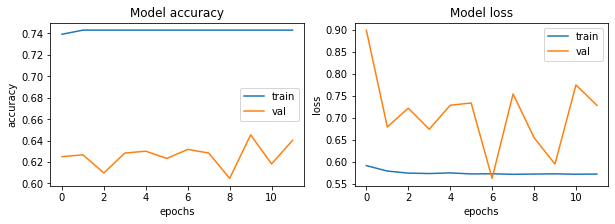

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(train_drop_history.history[met])
    ax[i].plot(train_drop_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((train_history.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[8 0]
 [8 0]]

TEST METRICS ----------------------
Accuracy: 50.0%
Precision: nan%
Recall: 0.0%
F1-score: nan

TRAIN METRIC ----------------------


C:\Users\Mauricio\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in longlong_scalars
  del sys.path[0]


NameError: name 'train_history' is not defined